<h2 align=center>Analyze Worldwide Box Office Data with Seaborn and Python (Part 1)</h2>
<img src="revenue.png">

### Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task 1: Data Loading and Exploration

In [2]:
train=pd.read_csv('train.csv')

In [3]:
test=pd.read_csv('test.csv')

## Take Log Transform Because of Being Right Skewed

### Task 2: Visualizing the Target Distribution

Text(0.5, 1.0, 'Distribution of Log Transformed Revenue')

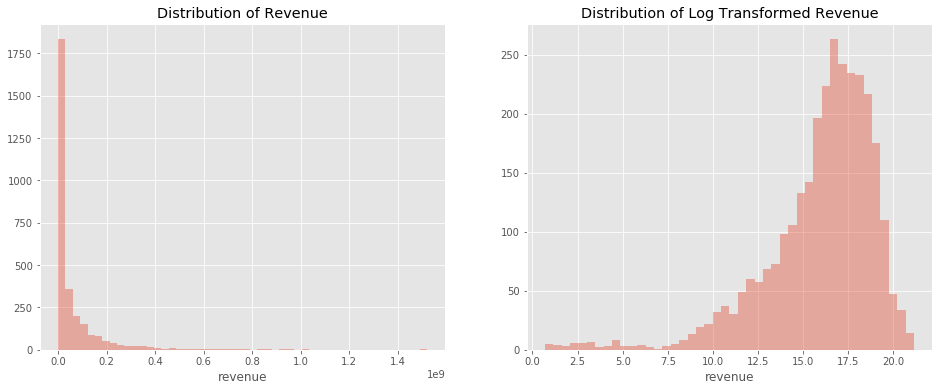

In [4]:
fig , ax =plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(train['revenue'],kde=False)
plt.title("Distribution of Revenue")
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['revenue']),kde=False)
plt.title("Distribution of Log Transformed Revenue")

In [5]:
train['log_revenue']=np.log1p(train['revenue'])

### Task 3: Relationship between Film Revenue and Budget

Text(0.5, 1.0, 'Log Revenue vs Log Budget')

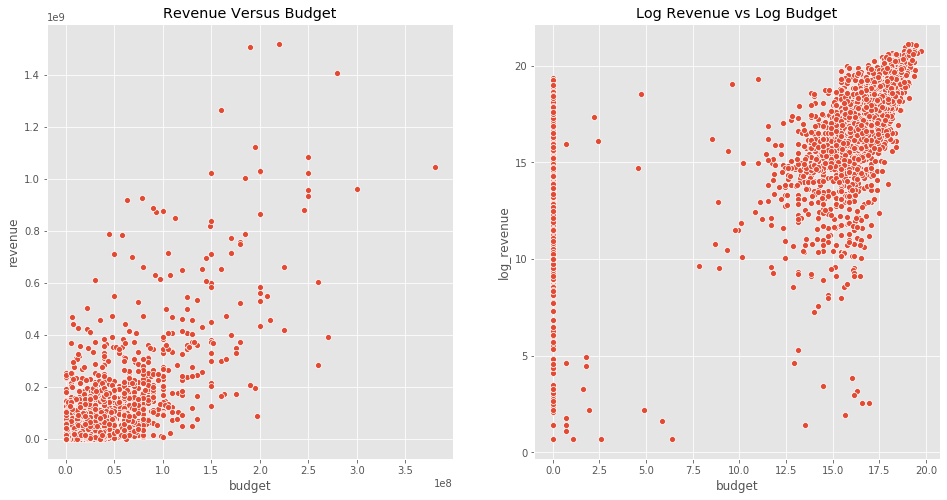

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'],train['revenue'])
plt.title('Revenue Versus Budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']),train['log_revenue'])
plt.title('Log Revenue vs Log Budget')

In [7]:
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])

### Task 4: Does having an Official Homepage Affect Revenue?

In [8]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                          4
http://www.thehobbit.com/                                  2
http://www.lordoftherings.net/                             2
http://drcabbie.com                                        1
http://www.magpictures.com/drinkingbuddies                 1
http://snowdenfilm.com/                                    1
http://www.thespiritofvengeance.com/                       1
http://www.ifcfilms.com/films/the-man-who-knew-infinity    1
http://www.projectalmanac.com/                             1
http://www.mgm.com/view/movie/2029/Tomorrow-Never-Dies/    1
Name: homepage, dtype: int64

In [9]:
train['homepage'].notnull()

0       False
1       False
2        True
3        True
4       False
5       False
6        True
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15       True
16      False
17      False
18      False
19      False
20      False
21      False
22       True
23       True
24       True
25      False
26      False
27      False
28      False
29      False
        ...  
2970    False
2971    False
2972    False
2973    False
2974    False
2975     True
2976    False
2977     True
2978    False
2979     True
2980     True
2981    False
2982    False
2983    False
2984     True
2985     True
2986    False
2987    False
2988    False
2989    False
2990    False
2991    False
2992    False
2993     True
2994    False
2995    False
2996    False
2997    False
2998     True
2999     True
Name: homepage, Length: 3000, dtype: bool

In [10]:
train.tail(4)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

## Creating Binary Features 
 when homepage value  is not null(matlab it has home page) set has_homepage  value to 1 

In [11]:
train['has_homepage']=0
train.loc[train['homepage'].notnull() == True , 'has_homepage'] =1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() ==  False, 'has_homepage' ] = 1

Text(0.5, 1, 'Revenue for films With and without a homePage')

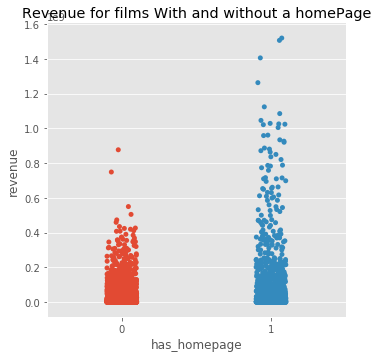

In [12]:
sns.catplot(x='has_homepage',y='revenue', data=train);
plt.title('Revenue for films With and without a homePage')

#### Pandas isin() method is used to filter data frames. isin() method helps in selecting rows with having a particular(or Multiple) value in a particular column.

### Task 5: Distribution of Languages in Film

Returns All those Rows where languages are as follow :
'en', 'fr', 'ru', 'es', 'hi', 'ja', 'it', 'cn', 'ko', 'zh'

In [13]:
language_data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

Text(0.5, 1.0, 'Mean Log Revenue Per Language')

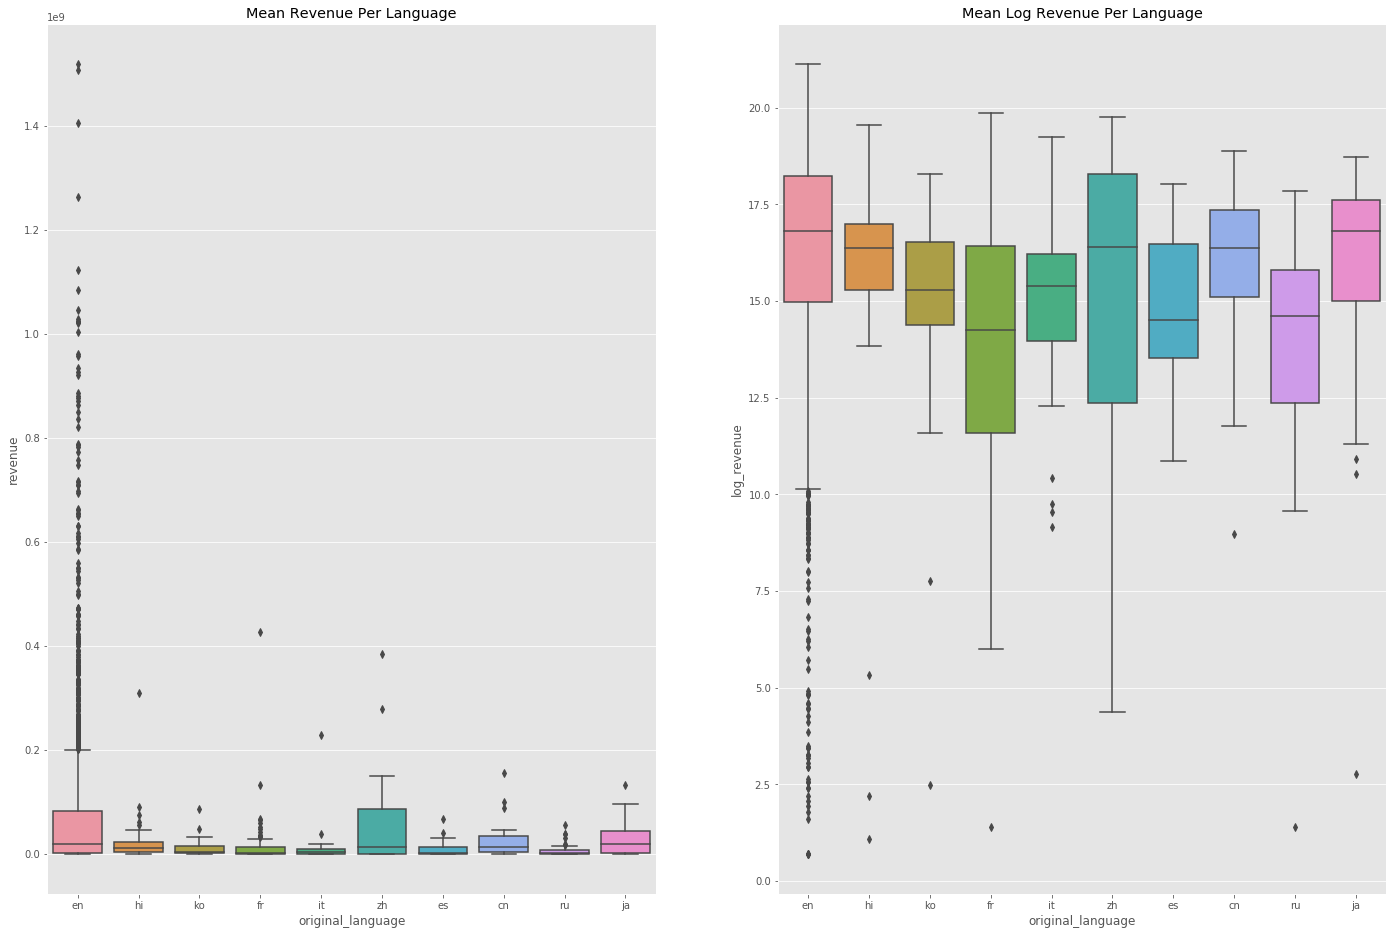

In [14]:
#Widht,height
plt.figure(figsize=(24,16))
plt.subplot(1,2,1)
sns.boxplot(x='original_language',y='revenue',data=language_data)
plt.title("Mean Revenue Per Language")
plt.subplot(1,2,2)
sns.boxplot(x='original_language',y='log_revenue',data=language_data)
plt.title("Mean Log Revenue Per Language")

### Task 6: Frequent Words in Film Titles and Descriptions

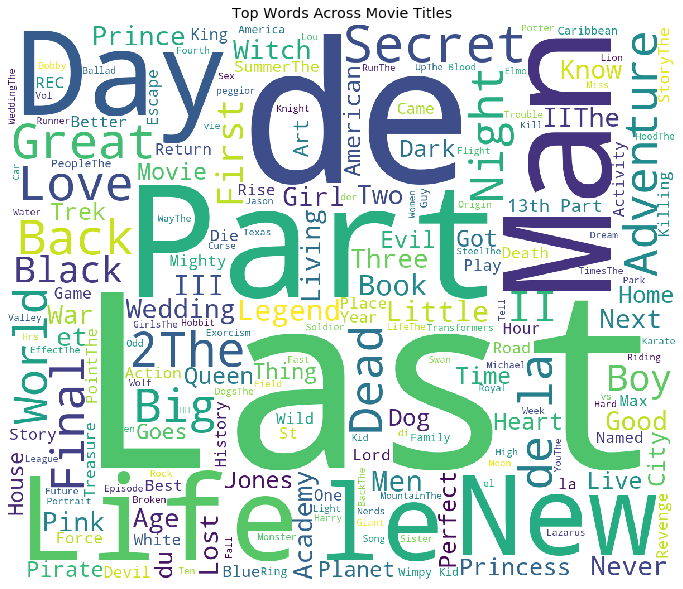

In [15]:
plt.figure(figsize=(12,12))
text = ''.join(train['original_title'].values)
wordcloud = WordCloud ( max_font_size = None ,
                       background_color='white',
                       width=1200,height=1000).generate(text)
plt.imshow(wordcloud)
plt.title("Top Words Across Movie Titles")
plt.axis('off')
plt.show()

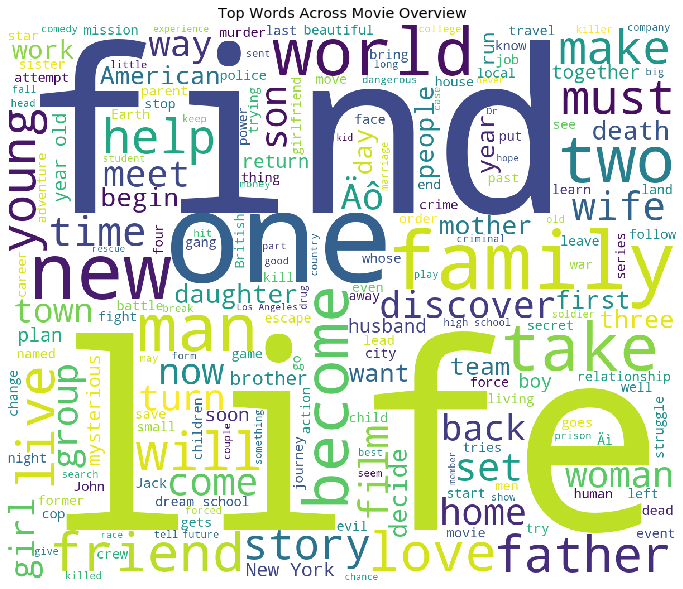

In [16]:
plt.figure(figsize=(12,12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud ( max_font_size = None ,
                       background_color='white',
                       width=1200,height=1000).generate(text)
plt.imshow(wordcloud)
plt.title("Top Words Across Movie Overview")
plt.axis('off')
plt.show()

### Task 7: Do Film Descriptions Impact Revenue?

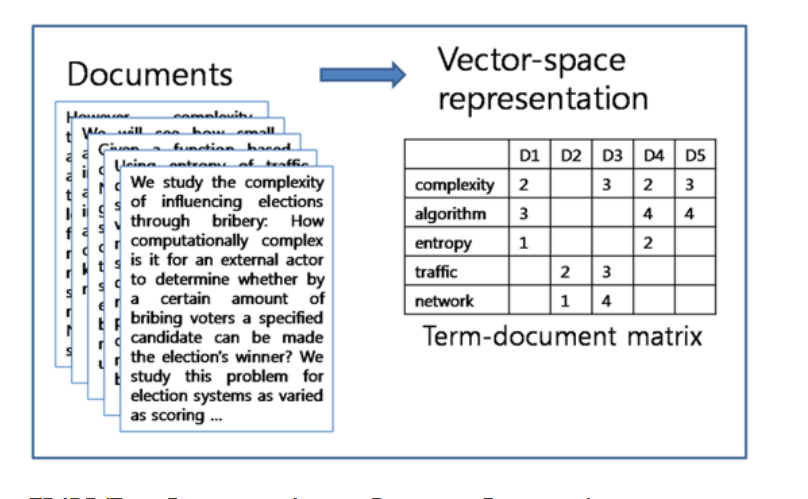

In [17]:
import eli5
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [23]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)
overview_text=vectorizer.fit_transform(train['overview'].fillna(''))
linreg=LinearRegression()
linreg.fit(overview_text,train['log_revenue'])
eli5.show_weights(linreg,vec=vectorizer,top=50,feature_filter=lambda x:x != '<BIAS>')

Weight?,Feature
+13.074,to
+10.131,bombing
+9.981,the
+9.777,complications
+9.243,äì
+9.191,and get
+8.850,at it
+8.765,california
+8.749,that this
+8.669,others
